In [1]:
library(tidyverse)
library(ebnm)
library(glue)
library(foreach)

theme_set(theme_minimal())

file_path <- "~/eb-selection"

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──



✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1



── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()




Attaching package: ‘foreach’




The following objects are masked from ‘package:purrr’:

    accumulate, when




In [2]:
# ==== Data retrieval ====
# Download the data from to store in https://osf.io/jd64p/
data_path <- glue("{file_path}/data")
filenames <- c(
    "upworthy-archive-confirmatory-packages-03.12.2020.csv",
    "upworthy-archive-exploratory-packages-03.12.2020.csv",
    "upworthy-archive-holdout-packages-03.12.2020.csv"
)

upworthy_rawdata <- lapply(
    glue("{data_path}/{filenames}"), read.csv, header = TRUE, na.strings = "NA"
) %>%
    bind_rows()

upworthy_df <- upworthy_rawdata %>%
    select(clickability_test_id, impressions, clicks) %>%
    filter(impressions > 1000, clicks > 100) %>%
    group_by(clickability_test_id) %>%
    filter(n() >= 2) %>%
    slice_max(impressions, n = 2, with_ties = FALSE) %>%
    mutate(condition = ifelse(row_number() == 1, "control", "test")) %>%
    ungroup()

In [3]:
head(upworthy_df)

clickability_test_id,impressions,clicks,condition
<chr>,<int>,<int>,<chr>
51436063220cb800020002a6,4559,137,control
51436063220cb800020002a6,4419,122,test
51436063220cb800020002a7,5414,120,control
51436063220cb800020002a7,5268,112,test
51436063220cb800020002e3,5257,171,control
51436063220cb800020002e3,5248,246,test


In [4]:
true_df <- upworthy_df %>%
    mutate(
        mean = clicks / impressions,
        var_mean = mean * (1 - mean) / impressions
    ) %>%
    pivot_wider(
        id_cols = clickability_test_id,
        names_from = condition,
        values_from = c(mean, var_mean)
    ) %>%
    mutate(
        delta = mean_test - mean_control,
        se = sqrt(var_mean_test + var_mean_control)
    )

# Generates n random values based on the normal mixture g
rnormmix <- function(n, g) {
    comp_count <- rmultinom(1, n, g$pi)
    i <- unlist(lapply(seq_along(g$pi), function(i) rep(i, comp_count[i])))
    g$mean[i] + rnorm(n) * g$sd[i]
}

In [5]:
ebnm_objs <- list()

ebnm_objs$normal <- ebnm_normal(
    x = true_df$delta, s = true_df$se, mode = "estimate", output = output_all()
)
ebnm_objs$normmix <- ebnm_ash(
    x = true_df$delta,
    s = true_df$se,
    mixcompdist = "normal",
    pointmass = FALSE,
    output = output_all()
)
ebnm_objs$npmle <- ebnm_npmle(
    x = true_df$delta, s = true_df$se, output = output_all()
)

Warning message in ebnm_workhorse(x = x, s = s, mode = mode, scale = scale, g_init = g_init, :
“Since they're not well defined for nonzero modes, local false sign rates won't be returned.”


In [6]:
# Prior predictive check
set.seed(1)
n <- 1e4

prior_predictions <- lapply(
    ebnm_objs,
    function(ebnm_obj) {
        data.frame(
            x = rnormmix(n, ebnm_obj$fitted_g) +
                rnorm(n) * sample(true_df$se, n, replace = TRUE)
        )
    }
) %>%
    bind_rows(.id = "prior")

png 
  2

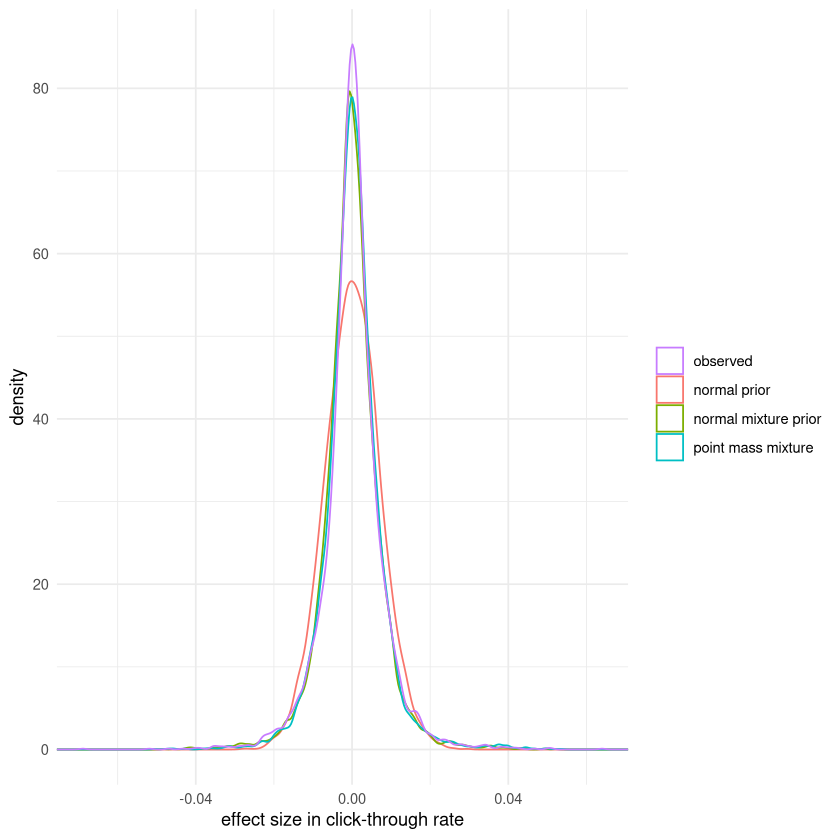

In [7]:
prior_predictive_plot <- rbind(
    data.frame(prior = "obs", x = true_df$delta),
    prior_predictions
) %>%
    ggplot() +
    geom_density(aes(x = x, group = prior, color = prior)) +
    coord_cartesian(xlim = range(true_df$delta)) +
    xlab("effect size in click-through rate") + 
    scale_color_discrete(
        name = element_blank(),
        breaks = c("obs", "normal", "normmix", "npmle"),
        labels = c(
            "observed",
            "normal prior",
            "normal mixture prior",
            "point mass mixture"
        )
    )

pdf(glue("{file_path}/delta.pdf"), width = 6, height = 4)
prior_predictive_plot
dev.off()

prior_predictive_plot

In [8]:
# Selecting normmix as the groundtruth since it looks like a reasonable fit
prior <- ebnm_objs$normmix$fitted_g

prior %>%
    with(data.frame(pi = pi, mean = mean, sd = sd)) %>%
    mutate(sd = sd / sqrt(mean(true_df$se^2))) %>%
    filter(pi > 0)

pi,mean,sd
<dbl>,<dbl>,<dbl>
0.57268109,0,0.01504786
0.31566693,0,1.36197700
0.04437003,0,1.92612635
0.05610904,0,3.85225269
0.01117292,0,5.44790800


In [9]:
# Signal-to-noise ratios
n <- 1e6
set.seed(2)
signal_size <- sd(rnormmix(n, prior))
noise_size <- sd(rnorm(n) * sample(true_df$se, n, replace = TRUE))
snr <- signal_size / noise_size
data.frame(noise_inflation = c(1, 2, 4), snr = snr / c(1, 2, 4))

noise_inflation,snr
<dbl>,<dbl>
1,1.3822817
2,0.6911408
4,0.3455704


In [10]:
sim <- function(
    idx, num_exp, num_unit = Inf, noise_inflation = 1, alpha = 0.1
) {
    set.seed(idx)

    k <- floor(num_exp * alpha)
    mu <- rnormmix(num_exp, prior)
    se <- sample(true_df$se, num_exp, replace = TRUE) * noise_inflation
    if (!is.infinite(num_unit)) {
        est_se <- se * sqrt(rchisq(num_exp, df = num_unit) / num_unit)
    } else {
        est_se <- se
    }
    x <- mu + rnorm(num_exp) * se

    sim_ebnm_objs <- list()
    # oracle Bayes
    sim_ebnm_objs$oracle <- ebnm_ash(
        x = x,
        s = se,
        mixcompdist = "normal",
        pointmass = FALSE,
        g_init = prior,
        fix_g = TRUE
    )
    # empirical Bayes, norm
    sim_ebnm_objs$normal <- ebnm_normal(x = x, s = est_se, mode = "estimate")
    # empirical Bayes, normmix
    sim_ebnm_objs$normmix <- ebnm_ash(
        x = x,
        s = est_se,
        mixcompdist = "normal",
        mode = 0,
        pointmass = FALSE,
        scale = prior$sd
    )
    # empirical Bayes, npmle
    sim_ebnm_objs$npmle <- ebnm_npmle(x = x, s = est_se)

    result1 <- lapply(
        sim_ebnm_objs,
        function(ebnm_obj) ebnm_obj$posterior$mean
    ) %>%
        bind_cols() %>%
        mutate(naive = x, i = row_number()) %>%
        rename(theta = oracle) %>%
        pivot_longer(
            -c(i, theta), names_to = "prior", values_to = "theta_hat"
        ) %>%
        group_by(prior) %>%
        mutate(oracle_j = rank(-theta) <= k, j = rank(-theta_hat) <= k) %>%
        summarize(
            regret = (sum(theta[oracle_j]) - sum(theta[j])) / n(),
            prop_mistakes = mean(oracle_j != j),
            magnitude = max(abs(theta - theta_hat)[oracle_j != j], 0),
            .groups = "drop"
        )
    sim_ebnm_objs["oracle"] <- NULL
    result2 <- lapply(
        sim_ebnm_objs,
        function(ebnm_obj) {
            mean(
                abs(
                    sort(rnormmix(1e6, prior)) -
                        sort(rnormmix(1e6, ebnm_obj$fitted_g))
                )
            )
        }
    ) %>%
        data.frame() %>%
        pivot_longer(everything(), names_to = "prior", values_to = "w1")
    result1 %>%
        full_join(result2, by = "prior") %>%
        mutate(
            idx = idx,
            num_exp = num_exp,
            num_unit = num_unit,
            noise_inflation = noise_inflation,
            alpha = alpha
        )
}

In [11]:
if (!file.exists(glue("{file_path}/regret-results.rds"))) {
    num_exp <- c(10, 30, 100, 300, 1000, 3000, 10000)
    noise_inflation <- c(1, 2, 4)
    num_sim <- 1000

    grid_df <- expand.grid(
        idx = 1:num_sim, num_exp = num_exp, noise_inflation = noise_inflation
    )
    start.time <- Sys.time()
    regret_results <- foreach(
        idx = grid_df$idx,
        num_exp = grid_df$num_exp,
        noise_inflation = grid_df$noise_inflation,
        .combine = "rbind",
        .errorhandling = 'remove'
    ) %do% {
        sim(idx, num_exp, num_unit = Inf, noise_inflation, alpha = 0.1)
    }
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    time.taken

    regret_results <- bind_rows(regret_results)
    saveRDS(regret_results, file = glue("{file_path}/regret-results.rds"))
} else {
    regret_results <- readRDS(glue("{file_path}/regret-results.rds"))
}
head(regret_results)

prior,regret,prop_mistakes,magnitude,w1,idx,num_exp,num_unit,noise_inflation,alpha
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
naive,0,0,0,NA,1,10,Inf,1,0.1
normal,0,0,0,0.002248788,1,10,Inf,1,0.1
normmix,0,0,0,0.002243585,1,10,Inf,1,0.1
npmle,0,0,0,0.002132961,1,10,Inf,1,0.1
naive,0,0,0,NA,2,10,Inf,1,0.1
normal,0,0,0,0.004094480,2,10,Inf,1,0.1


In [12]:
summarize_results <- function(results) {
    results_summary <- results %>%
        pivot_longer(
            cols = c(regret, prop_mistakes, magnitude, w1),
            names_to = "quantity",
            values_to = "value",
            values_drop_na = TRUE
        ) %>%
        group_by(across(c(-value, -idx))) %>%
        summarize(
            p99_value = quantile(value, 0.99, names = FALSE),
            p99_cil = quantile(value, 0.983, names = FALSE),
            p99_cih = quantile(value, 0.996, names = FALSE),
            mean_value = mean(value[quantity != "magnitude" | value > 0]),
            mean_se = sqrt(
                var(value[quantity != "magnitude" | value > 0]) /
                    sum(quantity != "magnitude" | value > 0)
            ),
            .groups = "drop"
        ) %>%
        mutate(
            mean_cil = mean_value + qnorm(0.025) * mean_se,
            mean_cih = mean_value + qnorm(0.975) * mean_se
        ) %>%
        select(-mean_se) %>%
        pivot_longer(
            cols = c(p99_value, p99_cil, p99_cih, mean_value, mean_cil, mean_cih),
            names_to = c("stat", ".value"),
            names_sep = "_"
        ) %>%
        mutate(
            prior = factor(
                prior, levels = c("normal", "normmix", "npmle", "naive")
            )
        )

    fitted_summary <- results_summary %>%
        filter(prior == "normmix") %>%
        group_by(quantity, stat, noise_inflation) %>%
        mutate(
            theoretical_slope = ifelse(quantity == "regret", -1, -1/2),
            fitted_value = exp(
                mean(log(value) - theoretical_slope * log(num_exp)) +
                    theoretical_slope * log(num_exp)
            )
        ) %>%
        select(prior, quantity, stat, noise_inflation, num_exp, fitted_value)

    results_summary %>%
        left_join(
            fitted_summary,
            by = c("prior", "quantity", "stat", "noise_inflation", "num_exp")
        )
}

regret_summary <- summarize_results(regret_results)

In [13]:
prior_labels <- c(
    "normal" = "EB-NN",
    "normmix" = "EB-NSM",
    "npmle" = "EB-NPMLE",
    "naive" = "unshrunk"
)
snr_labels <- c(
    "1" = "1x noise",
    "2" = "2x noise",
    "4" = "4x noise"
)
stat_labels <- c(
    "mean" = "mean",
    "p99" = expression(q[0.99])
)

common_aes <- aes(x = num_exp, group = stat, color = stat)
plot_settings <- list(
    geom_point(aes(y = value)),
    geom_line(aes(y = fitted_value), linetype = "dashed"),
    geom_errorbar(aes(ymin = cil, ymax = cih), width = 0.2, alpha = 0.5),
    scale_x_log10(),
    scale_y_log10(),
    scale_color_discrete(labels = stat_labels),
    scale_linetype_discrete(labels = stat_labels)
)
regret_facet_grid_settings <- facet_grid(
    noise_inflation ~ prior,
    labeller = labeller(
        prior = prior_labels, noise_inflation = snr_labels
    )
)

labs_settings <- list(
    regret = labs(
        x = "number of experiments",
        y = "regret (normalized)",
        linetype = "stat"
    ),
    prop_mistakes = labs(
        x = "number of experiments",
        y = "proportion of mistakes",
        linetype = "stat"
    ),
    magnitude = labs(
        x = "number of experiments",
        y = "magnitude of mistakes",
        linetype = "stat"
    ),
    w1 = labs(
        x = "number of experiments",
        y = "1-wasserstein distance",
        linetype = "stat"
    )
)

In [14]:
# Plot regret, should decay at n^-1
regret_plot <- regret_summary %>%
    filter(quantity == "regret") %>%
    mutate(
        across(c(value, fitted_value, cil, cih), function(x) x / noise_size)
    ) %>%
    ggplot(common_aes) +
    regret_facet_grid_settings +
    plot_settings +
    labs_settings["regret"]

pdf(glue("{file_path}/regret.pdf"), width = 6, height = 4)
regret_plot
dev.off()

# Plot proportion of mistakes, should decay at n^-1/2
prop_mistakes_plot <- regret_summary %>%
    filter(quantity == "prop_mistakes") %>%
    ggplot(common_aes) +
    regret_facet_grid_settings +
    plot_settings +
    labs_settings["prop_mistakes"]

pdf(glue("{file_path}/prop-mistakes.pdf"), width = 6, height = 4)
prop_mistakes_plot
dev.off()

# Plot magnitude, should decay at n^-1/2
magnitude_plot <- regret_summary %>%
    filter(quantity == "magnitude") %>%
    mutate(
        across(c(value, fitted_value, cil, cih), function(x) x / noise_size)
    ) %>%
    ggplot(common_aes) +
    regret_facet_grid_settings +
    plot_settings +
    labs_settings["magnitude"]

pdf(glue("{file_path}/magnitude.pdf"), width = 6, height = 4)
magnitude_plot
dev.off()

# Plot 1-wasserstein distance, should decay at n^-1/2
w1_plot <- regret_summary %>%
    filter(quantity == "w1") %>%
    mutate(
        across(c(value, fitted_value, cil, cih), function(x) x / noise_size)
    ) %>%
    ggplot(common_aes) +
    regret_facet_grid_settings +
    plot_settings +
    labs_settings["w1"]

pdf(glue("{file_path}/w1.pdf"), width = 6, height = 4)
w1_plot
dev.off()

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


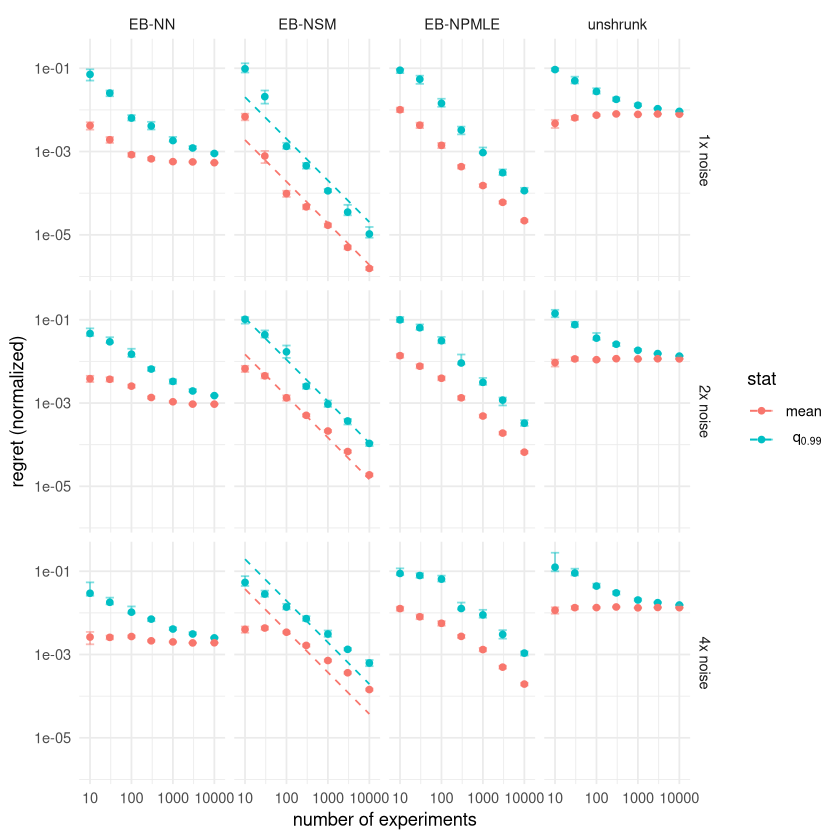

In [15]:
regret_plot

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


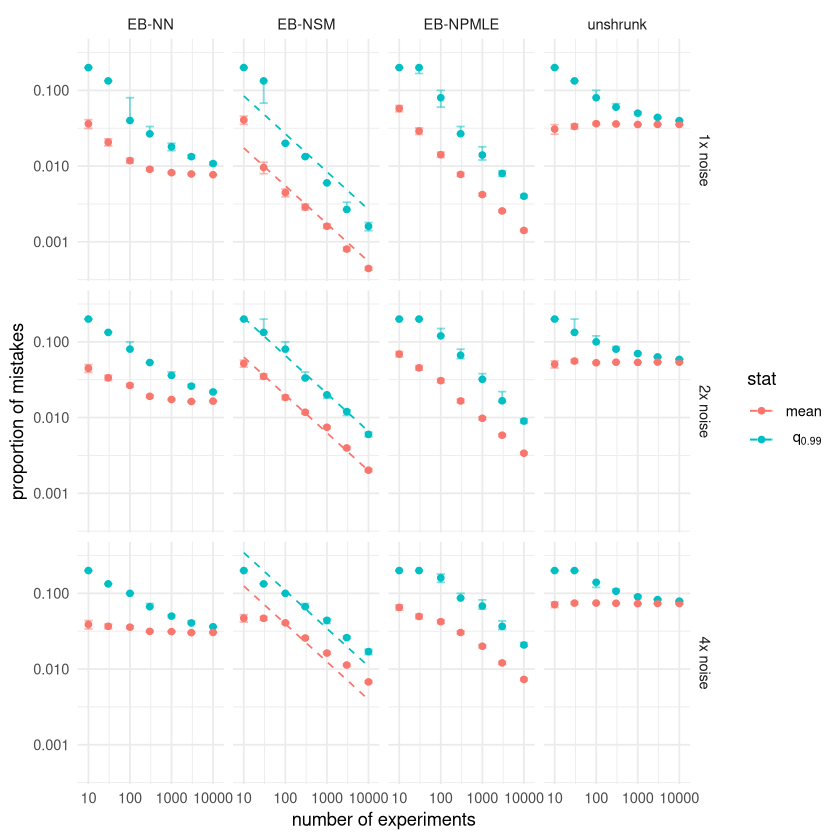

In [16]:
prop_mistakes_plot

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


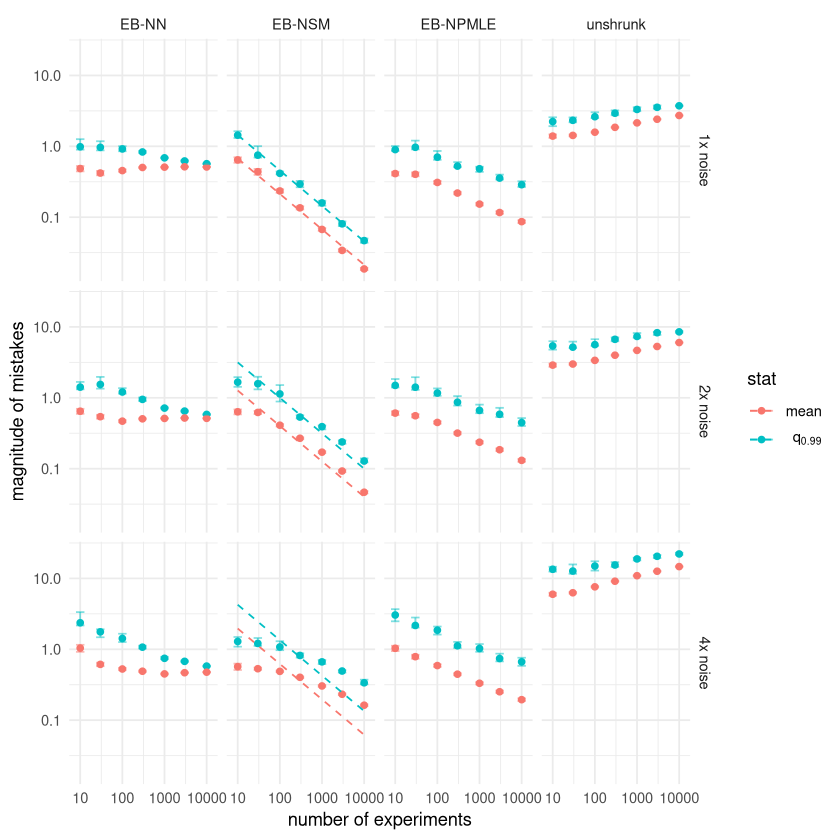

In [17]:
magnitude_plot

Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


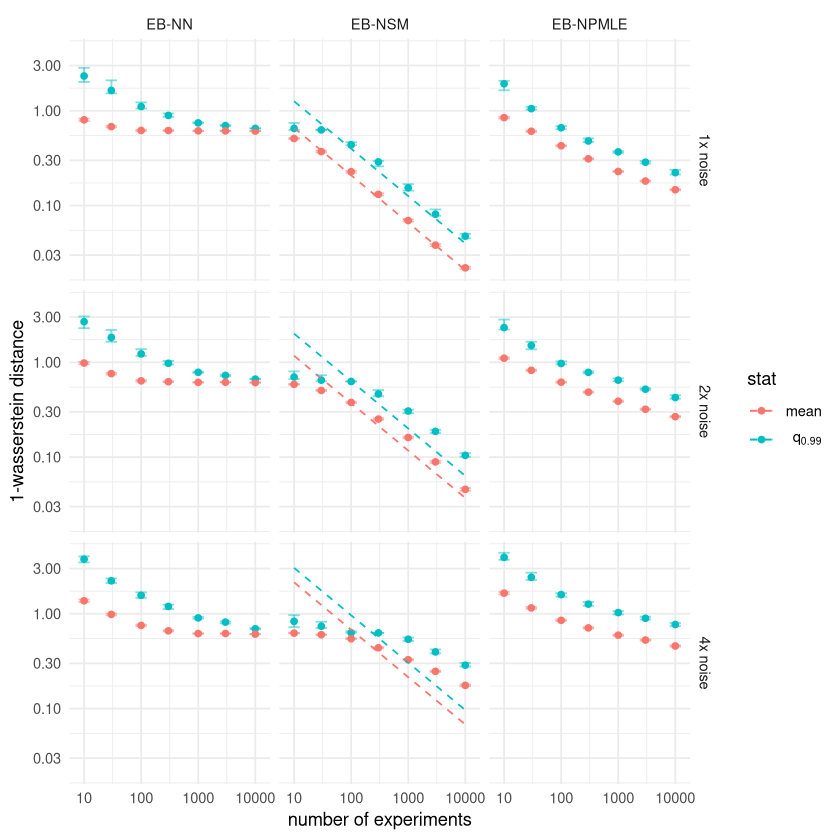

In [18]:
w1_plot

In [19]:
if (!file.exists(glue("{file_path}/regret-est-se-results.rds"))) {
    num_exp <- c(10, 30, 100, 300, 1000, 3000, 10000)
    num_unit <- c(100, 1000, 10000)
    num_sim <- 1000

    grid_df <- expand.grid(
        idx = 1:num_sim, num_exp = num_exp, num_unit = num_unit
    )
    start.time <- Sys.time()
    regret_est_se_results <- foreach(
        idx = grid_df$idx,
        num_exp = grid_df$num_exp,
        num_unit = grid_df$num_unit,
        .combine = "rbind",
        .errorhandling = 'remove'
    ) %do% {
        sim(idx, num_exp, num_unit, noise_inflation = 1, alpha = 0.1)
    }
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    time.taken

    # regret_est_se_results <- bind_rows(regret_est_se_results)
    saveRDS(
        regret_est_se_results,
        file = glue("{file_path}/regret-est-se-results.rds")
    )
} else {
    regret_est_se_results <- readRDS(
        glue("{file_path}/regret-est-se-results.rds")
    )
}
head(regret_est_se_results)

prior,regret,prop_mistakes,magnitude,w1,idx,num_exp,num_unit,noise_inflation,alpha
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
naive,0.0001616875,0.2,0.01027029,NA,1,10,100,1,0.1
normal,0.0000000000,0.0,0.00000000,0.004322381,1,10,100,1,0.1
normmix,0.0000000000,0.0,0.00000000,0.002245560,1,10,100,1,0.1
npmle,0.0000000000,0.0,0.00000000,0.004390064,1,10,100,1,0.1
naive,0.0000000000,0.0,0.00000000,NA,2,10,100,1,0.1
normal,0.0000000000,0.0,0.00000000,0.002792225,2,10,100,1,0.1


In [20]:
regret_est_se_summary <- summarize_results(regret_est_se_results)

In [21]:
num_unit_labels <- c(
    "100" = "100 units",
    "1000" = "1000 units",
    "10000" = "10000 units"
)

regret_est_se_facet_grid_settings <- facet_grid(
    num_unit ~ prior,
    labeller = labeller(prior = prior_labels, num_unit = num_unit_labels)
)

In [22]:
# Plot regret, should decay at n^-1
regret_est_se_plot <- regret_est_se_summary %>%
    filter(quantity == "regret") %>%
    mutate(
        across(c(value, fitted_value, cil, cih), function(x) x / noise_size)
    ) %>%
    ggplot(common_aes) +
    regret_est_se_facet_grid_settings +
    plot_settings +
    labs_settings["regret"]

pdf(glue("{file_path}/regret-est-se.pdf"), width = 6, height = 4)
regret_est_se_plot
dev.off()

# Plot proportion of mistakes, should decay at n^-1/2
prop_mistakes_est_se_plot <- regret_est_se_summary %>%
    filter(quantity == "prop_mistakes") %>%
    ggplot(common_aes) +
    regret_est_se_facet_grid_settings +
    plot_settings +
    labs_settings["prop_mistakes"]

pdf(glue("{file_path}/prop-mistakes-est-se.pdf"), width = 6, height = 4)
prop_mistakes_est_se_plot
dev.off()

# Plot magnitude, should decay at n^-1/2
magnitude_est_se_plot <- regret_est_se_summary %>%
    filter(quantity == "magnitude") %>%
    mutate(
        across(c(value, fitted_value, cil, cih), function(x) x / noise_size)
    ) %>%
    ggplot(common_aes) +
    regret_est_se_facet_grid_settings +
    plot_settings +
    labs_settings["magnitude"]

pdf(glue("{file_path}/magnitude-est-se.pdf"), width = 6, height = 4)
magnitude_est_se_plot
dev.off()

# Plot 1-wasserstein distance, should decay at n^-1/2
w1_est_se_plot <- regret_est_se_summary %>%
    filter(quantity == "w1") %>%
    mutate(
        across(c(value, fitted_value, cil, cih), function(x) x / noise_size)
    ) %>%
    ggplot(common_aes) +
    regret_est_se_facet_grid_settings +
    plot_settings +
    labs_settings["w1"]

pdf(glue("{file_path}/w1-est-se.pdf"), width = 6, height = 4)
w1_est_se_plot
dev.off()

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


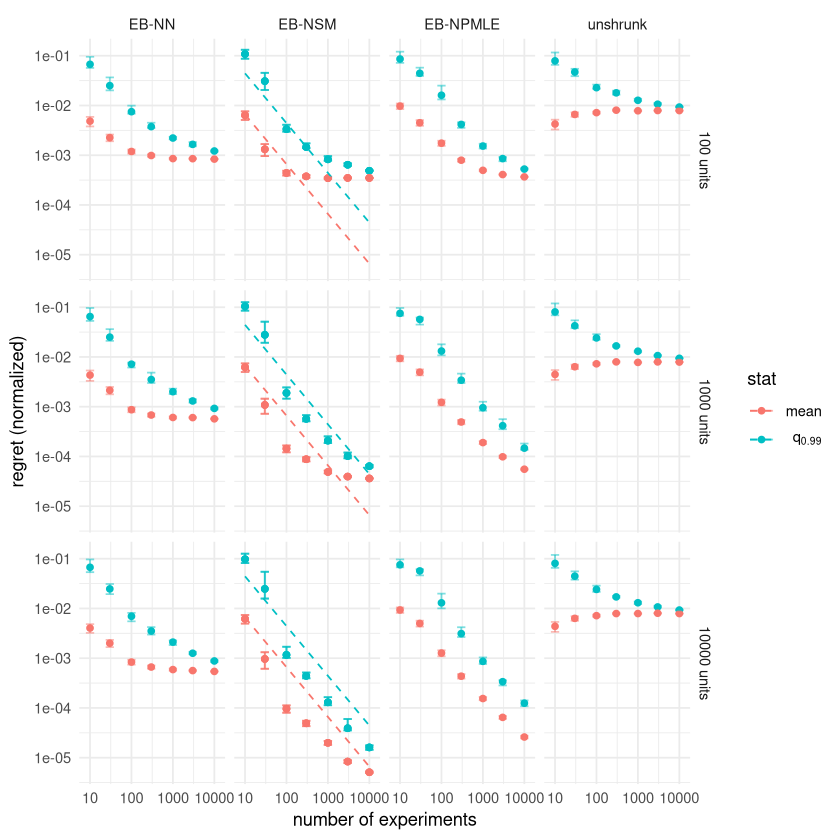

In [23]:
regret_est_se_plot

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


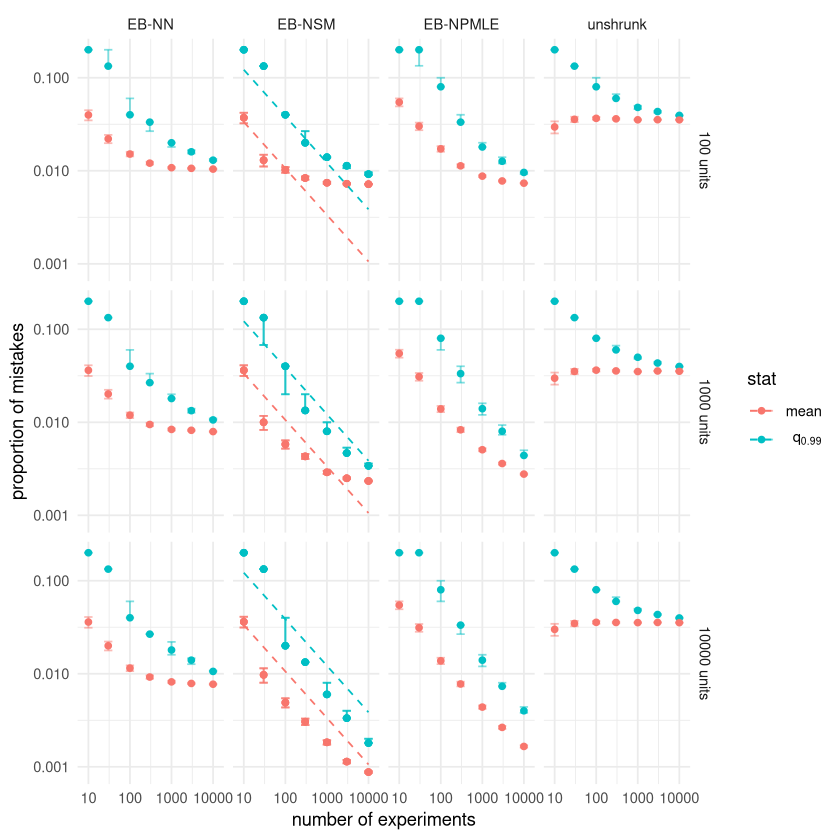

In [24]:
prop_mistakes_est_se_plot

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”


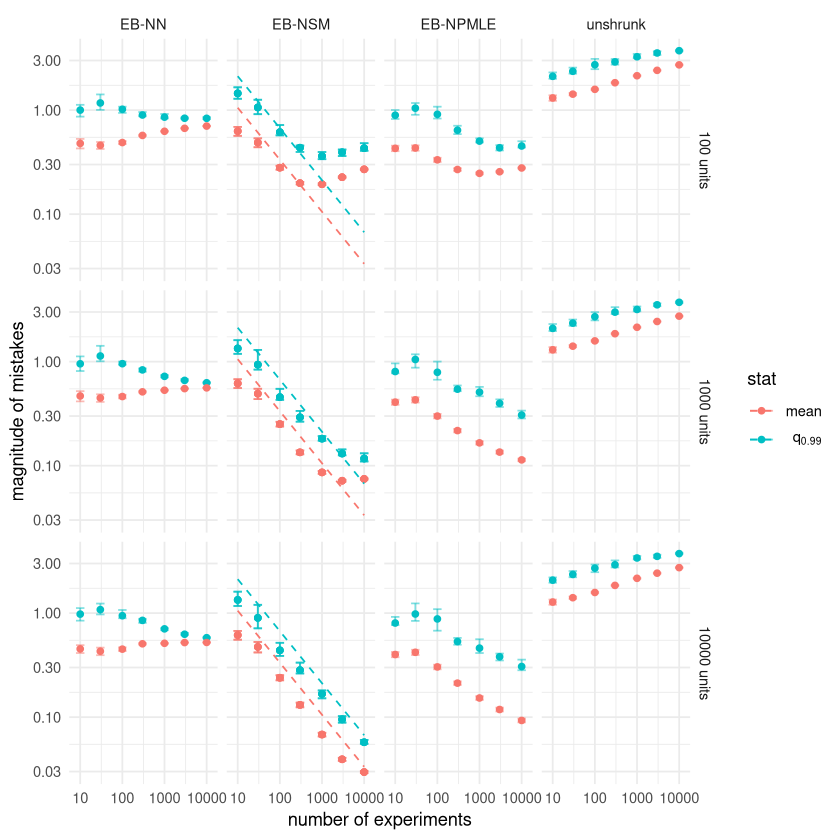

In [25]:
magnitude_est_se_plot

Warning message:
“Removed 28 row(s) containing missing values (geom_path).”


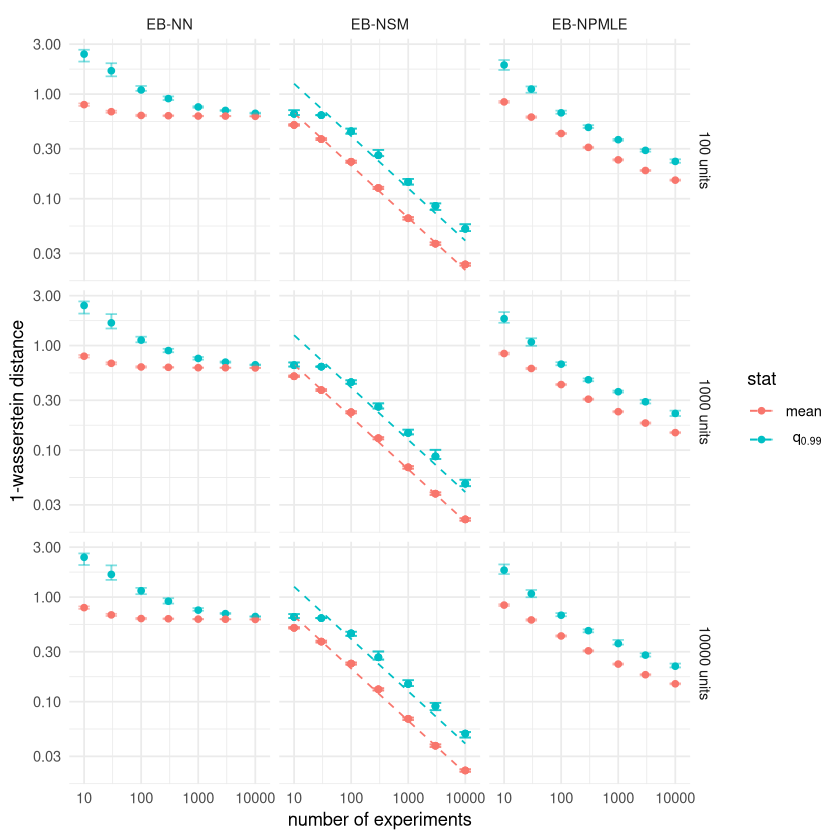

In [26]:
w1_est_se_plot